In [1]:
#create dictionary: ImagePath, array of FIXMAPS

import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re
import csv

grid_size = (20,20)
sigma = 1
def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.

    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h

    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)

    return horizontal_ppda

def checkObserverRemembered(observer, image_path, base_dir):
    csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
    if not os.path.isfile(csv_file_path):
        print("Error: CSV file not found.")
        return False
    df = pd.read_csv(csv_file_path)
    filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
    if not filtered_rows.empty:
        return True
    else:
        return False

distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
#print("ppda", ppda)

def bin_fixations(fixation_map):
    global grid_size
    height, width = fixation_map.shape
    binned_map = np.zeros(grid_size)

    bin_height = height // grid_size[0]
    bin_width = width // grid_size[1]

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            bin_area = fixation_map[i*bin_height:(i+1)*bin_height, j*bin_width:(j+1)*bin_width]
            binned_map[i, j] = np.sum(bin_area)
            #ili avg?

    return binned_map

def normalize_map(binned_map):
    return binned_map / np.sum(binned_map)
    #return binned_map

def smooth_map(binned_map):
    global sigma
    return gaussian_filter(binned_map, sigma=sigma)

def process_fixation_map(fixation_map):
    binned_map = bin_fixations(fixation_map)
    normalized_map = normalize_map(binned_map)
    smoothed_map = smooth_map(normalized_map)
    return smoothed_map

def get_current_fixation_map(image_path, coordinates):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    coordinates = coordinates[0:120]
  
    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        if(x_norm >0 and y_norm >0):
            x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm >0 and y_norm <0):
            x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm <0 and y_norm >0):
            x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        if(x_norm <0 and y_norm <0):
            x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
            y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1
    #sigma = ppda / np.sqrt(2)
    #fixation_map = gaussian_filter(fixation_map, sigma = sigma)
    fixation_map = cv2.GaussianBlur(fixation_map, (11,11), 0)
    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)
    return fixation_map

def normalize_fixation_map(fixation_map):
    min_val = np.min(fixation_map)
    max_val = np.max(fixation_map)
    normalized_fixation_map = (fixation_map - min_val) / (max_val - min_val) * 255
    return normalized_fixation_map

# 90experiments folder
base_dir = os.path.abspath(os.path.join(os.getcwd(),"..", "90experiments"))

fixation_maps = {}  # Dictionary to store fixation maps for each imagePath


for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())
    #if(observer != 5):
    #    continue
    if(observer == 1 or observer == 2 or observer == 49 or observer == 50 or observer == 5):
        continue

    #if(observer not in [70,71,73,74,76,77,79,80,82,83,85,87,88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
    #    continue
        
    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('targetImages')]
    
    uniqueImagePaths = []
    delete_rows = []

    #get only the eye-tracking data from the first viewing
    index = 0
    
    row = filtered_data.iloc[index]
    while len(uniqueImagePaths) < 10:
        row = filtered_data.iloc[index]
        if(row['ImagePath'] not in uniqueImagePaths):
            uniqueImagePaths.append(row['ImagePath'])
            lastImagePath = row['ImagePath']
            index +=1
        elif(row['ImagePath'] in uniqueImagePaths):
            index += 1    
    row = filtered_data.iloc[index]

    while(row['ImagePath'] == lastImagePath):
        index +=1
        row = filtered_data.iloc[index]

    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data = filtered_data.iloc[:index].copy()
    
    grouped = filtered_data.groupby('ImagePath')

    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))
        full_image_path = full_image_path.replace('\\', '/')

        #check if current observer has remembered this image, if not, continue
        if(not checkObserverRemembered(observer, image_path, base_dir)):
            continue
        
        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)
        if(np.all(current_fixation_map == 0)):
            continue

        current_fixation_map_20x20 = process_fixation_map(current_fixation_map)
        current_fixation_map_20x20 = normalize_fixation_map(current_fixation_map_20x20)
        
        #current_fixation_map_20x20 = (current_fixation_map)
        #add to dictionary or update it
        if image_path not in fixation_maps:
            fixation_maps[image_path] = [current_fixation_map_20x20]
        else:
            fixation_maps[image_path].append(current_fixation_map_20x20)

# Flatten the fixation maps and standardize them
all_fixation_maps = []
labels = []

for image_path, maps in fixation_maps.items():
    for fixation_map in maps:
        all_fixation_maps.append(fixation_map.flatten())
        labels.append(image_path)

X = np.array(all_fixation_maps)
y = np.array(labels)


In [63]:
#MLP obican, 15 puta

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import collections
import cv2
import random

# Function to add Gaussian noise
def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image + gauss
    return np.clip(noisy, 0, 1)

# Function to apply Gaussian blur
def add_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Function to adjust contrast
def adjust_contrast(image, alpha=1.0, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

trainings = 15
best_accuracy = 0

for i in range(trainings):
    X = X.reshape(-1, 20, 20, 1)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    label_names = label_encoder.classes_
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, stratify=y_encoded)
    
    y_train_categorical = to_categorical(y_train, num_classes=len(label_encoder.classes_))
    y_test_categorical = to_categorical(y_test, num_classes=len(label_encoder.classes_))
    
    # Apply SMOTE to balance the dataset
    X_train_flatten = X_train.reshape(X_train.shape[0], -1)
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flatten, np.argmax(y_train_categorical, axis=1))
    
    # Reshape X_train back to original shape
    X_train_resampled = X_train_resampled.reshape(-1, 20, 20, 1)
    y_train_resampled_categorical = np.eye(len(label_encoder.classes_))[y_train_resampled]
    
    # Calculate class weights
    class_counts = collections.Counter(np.argmax(y_train_resampled_categorical, axis=1))
    total_samples = sum(class_counts.values())
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Augment the data
    augmented_data = []
    augmented_labels = []

    for img, label in zip(X_train_resampled, y_train_resampled_categorical):
        augmented_data.append(img)
        augmented_labels.append(label)
        
        # Add Gaussian noise
        noisy_image = add_gaussian_noise(img)
        noisy_image = noisy_image.reshape(20, 20, 1)  # Ensure correct shape
        augmented_data.append(noisy_image)
        augmented_labels.append(label)
        
        # Add blur
        blurred_image = add_blur(img)
        blurred_image = blurred_image.reshape(20, 20, 1)  # Ensure correct shape
        augmented_data.append(blurred_image)
        augmented_labels.append(label)
        
        # Adjust contrast
        contrast_image = adjust_contrast(img, alpha=random.uniform(0.5, 1.5), beta=random.uniform(-50, 50))
        contrast_image = contrast_image.reshape(20, 20, 1)  # Ensure correct shape
        augmented_data.append(contrast_image)
        augmented_labels.append(label)

    X_train_augmented = np.array(augmented_data)
    y_train_augmented = np.array(augmented_labels)
    
    # Define the MLP model
    model = Sequential([
        Flatten(input_shape=(20, 20, 1)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    # Callbacks for learning rate adjustment and early stopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=40, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train_augmented, y_train_augmented,
                        validation_data=(X_test, y_test_categorical),
                        epochs=1000,
                        callbacks=[reduce_lr, early_stopping],
                        class_weight=class_weights,
                        batch_size=64
                        )
    
    # Evaluate the model
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        print(f"Accuracy: {accuracy:.4f}")
    
print(best_accuracy)

# Print classification report
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
'''
# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()'''


Epoch 1/1000


C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1098 - loss: 123.9531 - top_k_categorical_accuracy: 0.3096 - val_accuracy: 0.3636 - val_loss: 4.3983 - val_top_k_categorical_accuracy: 0.6727 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 85.3809 - top_k_categorical_accuracy: 0.5443 - val_accuracy: 0.4545 - val_loss: 3.6935 - val_top_k_categorical_accuracy: 0.6909 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3328 - loss: 75.3219 - top_k_categorical_accuracy: 0.6353 - val_accuracy: 0.4727 - val_loss: 3.5471 - val_top_k_categorical_accuracy: 0.6909 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3984 - loss: 68.1610 - top_k_categorical_accuracy: 0.6650 - val_accuracy: 0.4545 - val_loss: 3.4603 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3962 - loss: 66.7537 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1005 - loss: 123.0802 - top_k_categorical_accuracy: 0.3071 - val_accuracy: 0.3636 - val_loss: 4.4730 - val_top_k_categorical_accuracy: 0.6364 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2992 - loss: 84.3899 - top_k_categorical_accuracy: 0.5582 - val_accuracy: 0.4182 - val_loss: 3.4963 - val_top_k_categorical_accuracy: 0.7455 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3301 - loss: 77.1927 - top_k_categorical_accuracy: 0.6034 - val_accuracy: 0.4182 - val_loss: 3.3281 - val_top_k_categorical_accuracy: 0.7455 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3799 - loss: 69.0569 - top_k_categorical_accuracy: 0.6515 - val_accuracy: 0.4545 - val_loss: 3.2017 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4173 - loss: 64.7268 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0909 - loss: 125.5959 - top_k_categorical_accuracy: 0.2806 - val_accuracy: 0.3636 - val_loss: 4.8237 - val_top_k_categorical_accuracy: 0.6909 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2907 - loss: 86.0807 - top_k_categorical_accuracy: 0.5341 - val_accuracy: 0.3455 - val_loss: 4.2624 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3528 - loss: 74.3251 - top_k_categorical_accuracy: 0.6225 - val_accuracy: 0.3455 - val_loss: 3.6710 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3792 - loss: 69.7326 - top_k_categorical_accuracy: 0.6397 - val_accuracy: 0.3455 - val_loss: 3.6903 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4112 - loss: 65.1641 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0874 - loss: 128.0209 - top_k_categorical_accuracy: 0.3000 - val_accuracy: 0.3273 - val_loss: 4.7405 - val_top_k_categorical_accuracy: 0.6727 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2830 - loss: 87.3613 - top_k_categorical_accuracy: 0.5509 - val_accuracy: 0.4000 - val_loss: 3.8625 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3340 - loss: 77.1460 - top_k_categorical_accuracy: 0.6173 - val_accuracy: 0.4182 - val_loss: 3.6419 - val_top_k_categorical_accuracy: 0.7273 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3954 - loss: 69.6081 - top_k_categorical_accuracy: 0.6616 - val_accuracy: 0.4727 - val_loss: 3.4919 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4143 - loss: 63.7480 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0841 - loss: 130.4024 - top_k_categorical_accuracy: 0.2587 - val_accuracy: 0.4182 - val_loss: 4.0372 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2733 - loss: 87.7552 - top_k_categorical_accuracy: 0.5459 - val_accuracy: 0.4909 - val_loss: 3.6303 - val_top_k_categorical_accuracy: 0.7273 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3474 - loss: 75.9383 - top_k_categorical_accuracy: 0.6198 - val_accuracy: 0.4909 - val_loss: 3.3166 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3737 - loss: 69.6168 - top_k_categorical_accuracy: 0.6492 - val_accuracy: 0.4545 - val_loss: 3.4441 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4111 - loss: 64.4110 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0918 - loss: 125.4345 - top_k_categorical_accuracy: 0.2950 - val_accuracy: 0.4182 - val_loss: 3.7277 - val_top_k_categorical_accuracy: 0.8000 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2613 - loss: 87.0699 - top_k_categorical_accuracy: 0.5430 - val_accuracy: 0.4545 - val_loss: 3.5540 - val_top_k_categorical_accuracy: 0.8000 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3285 - loss: 76.3019 - top_k_categorical_accuracy: 0.6162 - val_accuracy: 0.4364 - val_loss: 3.3076 - val_top_k_categorical_accuracy: 0.7455 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3873 - loss: 68.4902 - top_k_categorical_accuracy: 0.6786 - val_accuracy: 0.4909 - val_loss: 3.2903 - val_top_k_categorical_accuracy: 0.8000 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4176 - loss: 65.0124 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1036 - loss: 124.6961 - top_k_categorical_accuracy: 0.3035 - val_accuracy: 0.3273 - val_loss: 5.2335 - val_top_k_categorical_accuracy: 0.5636 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2534 - loss: 86.2640 - top_k_categorical_accuracy: 0.5570 - val_accuracy: 0.3091 - val_loss: 4.3778 - val_top_k_categorical_accuracy: 0.6182 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3553 - loss: 73.9314 - top_k_categorical_accuracy: 0.6387 - val_accuracy: 0.4000 - val_loss: 4.1269 - val_top_k_categorical_accuracy: 0.6364 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3833 - loss: 68.0642 - top_k_categorical_accuracy: 0.6505 - val_accuracy: 0.4000 - val_loss: 3.9734 - val_top_k_categorical_accuracy: 0.6545 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4237 - loss: 65.3082 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0886 - loss: 126.4799 - top_k_categorical_accuracy: 0.2880 - val_accuracy: 0.4000 - val_loss: 4.2583 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2846 - loss: 86.1905 - top_k_categorical_accuracy: 0.5455 - val_accuracy: 0.4727 - val_loss: 3.8047 - val_top_k_categorical_accuracy: 0.7455 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3308 - loss: 76.4045 - top_k_categorical_accuracy: 0.6134 - val_accuracy: 0.4545 - val_loss: 3.5221 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3645 - loss: 72.7552 - top_k_categorical_accuracy: 0.6276 - val_accuracy: 0.5091 - val_loss: 3.3842 - val_top_k_categorical_accuracy: 0.8000 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4071 - loss: 66.2002 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0964 - loss: 125.7591 - top_k_categorical_accuracy: 0.2994 - val_accuracy: 0.3455 - val_loss: 3.9735 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2814 - loss: 86.8270 - top_k_categorical_accuracy: 0.5671 - val_accuracy: 0.4909 - val_loss: 3.2837 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3248 - loss: 76.1204 - top_k_categorical_accuracy: 0.6107 - val_accuracy: 0.5091 - val_loss: 3.1278 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3723 - loss: 71.6998 - top_k_categorical_accuracy: 0.6439 - val_accuracy: 0.5455 - val_loss: 2.9658 - val_top_k_categorical_accuracy: 0.7273 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3958 - loss: 66.8963 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0972 - loss: 124.1529 - top_k_categorical_accuracy: 0.3174 - val_accuracy: 0.4000 - val_loss: 4.5571 - val_top_k_categorical_accuracy: 0.6000 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2678 - loss: 86.4192 - top_k_categorical_accuracy: 0.5501 - val_accuracy: 0.4000 - val_loss: 3.8785 - val_top_k_categorical_accuracy: 0.6364 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3300 - loss: 74.6209 - top_k_categorical_accuracy: 0.6225 - val_accuracy: 0.4000 - val_loss: 3.5375 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3710 - loss: 71.0339 - top_k_categorical_accuracy: 0.6417 - val_accuracy: 0.4182 - val_loss: 3.3739 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4085 - loss: 64.9106 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0884 - loss: 128.6754 - top_k_categorical_accuracy: 0.2612 - val_accuracy: 0.4182 - val_loss: 4.9674 - val_top_k_categorical_accuracy: 0.7273 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2770 - loss: 85.4745 - top_k_categorical_accuracy: 0.5443 - val_accuracy: 0.4364 - val_loss: 4.2114 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3466 - loss: 74.5980 - top_k_categorical_accuracy: 0.6191 - val_accuracy: 0.4182 - val_loss: 3.8393 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3759 - loss: 69.3089 - top_k_categorical_accuracy: 0.6490 - val_accuracy: 0.4909 - val_loss: 3.7242 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4291 - loss: 62.7222 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1025 - loss: 125.2523 - top_k_categorical_accuracy: 0.2957 - val_accuracy: 0.3455 - val_loss: 4.7740 - val_top_k_categorical_accuracy: 0.6182 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2750 - loss: 84.9203 - top_k_categorical_accuracy: 0.5603 - val_accuracy: 0.3455 - val_loss: 4.1787 - val_top_k_categorical_accuracy: 0.6364 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3609 - loss: 73.3260 - top_k_categorical_accuracy: 0.6337 - val_accuracy: 0.4182 - val_loss: 3.6957 - val_top_k_categorical_accuracy: 0.6545 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3963 - loss: 68.8582 - top_k_categorical_accuracy: 0.6502 - val_accuracy: 0.4545 - val_loss: 3.6196 - val_top_k_categorical_accuracy: 0.6909 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4119 - loss: 65.5674 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0846 - loss: 125.3075 - top_k_categorical_accuracy: 0.2899 - val_accuracy: 0.3091 - val_loss: 4.2581 - val_top_k_categorical_accuracy: 0.6727 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2736 - loss: 86.6253 - top_k_categorical_accuracy: 0.5509 - val_accuracy: 0.4182 - val_loss: 3.6359 - val_top_k_categorical_accuracy: 0.6182 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3572 - loss: 72.7718 - top_k_categorical_accuracy: 0.6363 - val_accuracy: 0.4364 - val_loss: 3.3975 - val_top_k_categorical_accuracy: 0.6909 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4011 - loss: 68.7028 - top_k_categorical_accuracy: 0.6489 - val_accuracy: 0.4364 - val_loss: 3.4103 - val_top_k_categorical_accuracy: 0.6727 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4148 - loss: 64.7600 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0969 - loss: 125.9689 - top_k_categorical_accuracy: 0.2854 - val_accuracy: 0.3636 - val_loss: 4.5797 - val_top_k_categorical_accuracy: 0.6727 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2634 - loss: 86.1922 - top_k_categorical_accuracy: 0.5259 - val_accuracy: 0.4182 - val_loss: 3.7858 - val_top_k_categorical_accuracy: 0.7273 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3460 - loss: 75.9033 - top_k_categorical_accuracy: 0.6127 - val_accuracy: 0.4000 - val_loss: 3.6643 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3932 - loss: 69.0098 - top_k_categorical_accuracy: 0.6406 - val_accuracy: 0.4364 - val_loss: 3.8077 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4000 - loss: 66.0803 -

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0959 - loss: 125.3729 - top_k_categorical_accuracy: 0.3040 - val_accuracy: 0.3273 - val_loss: 5.0428 - val_top_k_categorical_accuracy: 0.6727 - learning_rate: 0.0010
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2940 - loss: 85.1543 - top_k_categorical_accuracy: 0.5565 - val_accuracy: 0.4000 - val_loss: 4.1505 - val_top_k_categorical_accuracy: 0.7091 - learning_rate: 0.0010
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3258 - loss: 77.3308 - top_k_categorical_accuracy: 0.5967 - val_accuracy: 0.4545 - val_loss: 3.7365 - val_top_k_categorical_accuracy: 0.7818 - learning_rate: 0.0010
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3791 - loss: 69.8982 - top_k_categorical_accuracy: 0.6451 - val_accuracy: 0.4364 - val_loss: 3.6684 - val_top_k_categorical_accuracy: 0.7636 - learning_rate: 0.0010
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4230 - loss: 63.6902 -

"\n# Plot training history\nplt.plot(history.history['accuracy'], label='train accuracy')\nplt.plot(history.history['val_accuracy'], label='val accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\n\nplt.plot(history.history['loss'], label='train loss')\nplt.plot(history.history['val_loss'], label='val loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()"

In [7]:
#LEave one out cross validation

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import collections

# Assuming X and y are already defined and X contains grayscale images
X = X.reshape(-1, 20, 20, 1)  # Reshape to include channel dimension

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to categorical format
y_categorical = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Define leave-one-out cross-validation
loo = LeaveOneOut()

# Initialize variables to store results
acc_per_fold = []
loss_per_fold = []
fold_no = 1

problematic_samples = []
high_loss_threshold = 3.0  # Define a threshold for high loss

for train, test in loo.split(X, y_encoded):
    model = Sequential([
        Input(shape=(grid_size[0], grid_size[1], 1)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(np.unique(y)), activation='softmax', kernel_regularizer=l2(0.001))
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Calculate class weights
    class_counts = collections.Counter(y_encoded[train])
    total_samples = sum(class_counts.values())
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=30, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    # Train the model
    history = model.fit(X[train], to_categorical(y_encoded[train], num_classes=len(label_encoder.classes_)),
                        class_weight=class_weights,
                        epochs=300,
                        validation_data=(X[test], to_categorical(y_encoded[test], num_classes=len(label_encoder.classes_))),
                        callbacks=[reduce_lr, early_stopping], verbose = 0)

    # Evaluate the model
    scores = model.evaluate(X[test], to_categorical(y_encoded[test], num_classes=len(label_encoder.classes_)), verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Store problematic samples
    if scores[0] > high_loss_threshold:
        problematic_samples.append(test[0])

    fold_no += 1

# Print the average accuracy and loss over all folds
print('Average accuracy over all folds:', np.mean(acc_per_fold))
print('Average loss over all folds:', np.mean(loss_per_fold))

# Print and remove problematic samples
print(f'Problematic samples (indices with loss > {high_loss_threshold}):', problematic_samples)

# Remove problematic samples from the dataset
X_filtered = np.delete(X, problematic_samples, axis=0)
y_filtered = np.delete(y_encoded, problematic_samples, axis=0)

print('Number of samples after removing problematic samples:', X_filtered.shape[0])


Score for fold 1: loss of 0.9145313501358032; compile_metrics of 100.0%
Score for fold 2: loss of 0.8997101187705994; compile_metrics of 100.0%
Score for fold 3: loss of 5.18798828125; compile_metrics of 0.0%
Score for fold 4: loss of 5.27087926864624; compile_metrics of 0.0%
Score for fold 5: loss of 0.8512699007987976; compile_metrics of 100.0%
Score for fold 6: loss of 1.3072110414505005; compile_metrics of 100.0%
Score for fold 7: loss of 2.512240171432495; compile_metrics of 0.0%
Score for fold 8: loss of 1.5243921279907227; compile_metrics of 100.0%
Score for fold 9: loss of 0.8665581345558167; compile_metrics of 100.0%
Score for fold 10: loss of 2.663489818572998; compile_metrics of 0.0%
Score for fold 11: loss of 1.3502180576324463; compile_metrics of 100.0%
Score for fold 12: loss of 3.0292389392852783; compile_metrics of 0.0%
Score for fold 13: loss of 1.3630461692810059; compile_metrics of 100.0%
Score for fold 14: loss of 5.265138149261475; compile_metrics of 0.0%
Score for

In [56]:
#SVM obican

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import collections


trainings = 50
best_accuracy = 0
best_params = {}


for i in range(trainings):
    X = X.reshape(-1, 20, 20, 1)
    X_flatten = X.reshape(X.shape[0], -1)  # Flatten the images
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    label_names = label_encoder.classes_
    
    X_train, X_test, y_train, y_test = train_test_split(X_flatten, y_encoded, test_size=0.2, stratify=y_encoded)
    
    # Apply SMOTE to balance the dataset
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train SVM
    svm_model = SVC(kernel='rbf', probability=True)
    svm_model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = svm_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    if (accuracy > best_accuracy):
        best_accuracy = accuracy
    # Print classification report
    #print(classification_report(y_test, y_pred))

print(f"Best accuracy: {best_accuracy:.4f} with parameters: {best_params}")


Best accuracy: 0.5273 with parameters: {}


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 1382.1094 - val_loss: 1415.4240
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1365.4756 - val_loss: 1412.9691
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1351.6201 - val_loss: 1410.8870
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1357.7664 - val_loss: 1409.2706
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1361.1189 - val_loss: 1407.9911
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1349.0718 - val_loss: 1407.1056
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1365.2745 - val_loss: 1406.5431
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1335.7625 - val_loss: 1405.9238
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1360.2411 - val_loss: 1405.6412
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1356.0171 - val_loss: 1405.5718
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1355.4091 - val_loss: 1405.4985
Epoch 12/50
2/2 ━━

C:\Users\valerijan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.0338 - loss: 5.0458 - val_accuracy: 0.1000 - val_loss: 8.1676 - learning_rate: 0.0010
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1275 - loss: 4.1216 - val_accuracy: 0.0364 - val_loss: 7.1914 - learning_rate: 0.0010
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1940 - loss: 3.5888 - val_accuracy: 0.0636 - val_loss: 5.6641 - learning_rate: 0.0010
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2182 - loss: 3.3319 - val_accuracy: 0.1455 - val_loss: 5.0593 - learning_rate: 0.0010
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2738 - loss: 3.1006 - val_accuracy: 0.1545 - val_loss: 4.6660 - learning_rate: 0.0010
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2891 - loss: 3.0240 - val_accuracy: 0.1636 - val_loss: 4.3390 - learning_rate: 0.0010
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2980 - loss: 2.8668 - val_accuracy: 0.1909 - val

C:\Users\valerijan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valerijan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\valerijan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


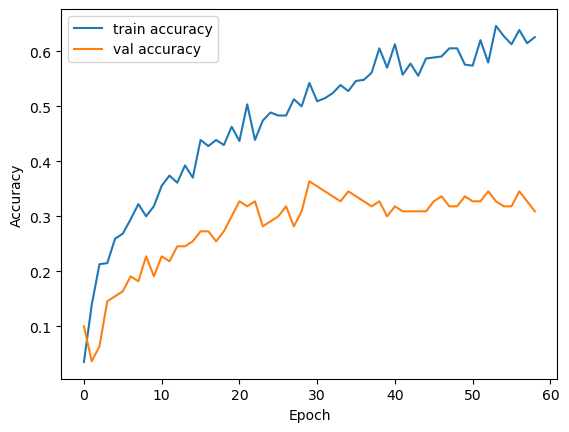

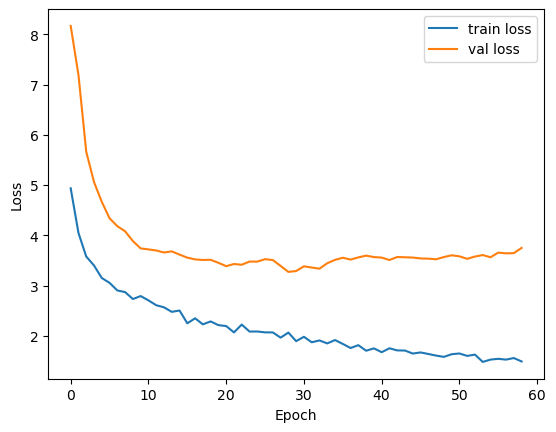

In [57]:
#Encoder code copied

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import collections

# Assuming X and y are already defined and X contains grayscale images
X = X.reshape(-1, 20, 20, 1)  # Reshape to include channel dimension

# Define the autoencoder
input_img = Input(shape=(20, 20, 1))
x = Flatten()(input_img)
encoded = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(20 * 20, activation='sigmoid')(decoded)
decoded = Reshape((20, 20, 1))(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Extract the encoder
encoder = Model(input_img, encoded)

# Encode the data
X_encoded = encoder.predict(X)

# Flatten the encoded data for the classifier
X_encoded_flatten = X_encoded.reshape(X_encoded.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded_flatten, y_encoded, test_size=0.2, stratify=y_encoded)

# Apply SMOTE to balance the dataset
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the MLP model for classification
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_resampled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the MLP model
mlp_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=30, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the MLP model
history = mlp_model.fit(X_train_resampled, y_train_resampled,
                        validation_data=(X_test, y_test),
                        epochs=1000,
                        callbacks=[reduce_lr, early_stopping],
                        batch_size=64)

# Evaluate the model
y_pred_prob = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
